In [90]:
import numpy as np
import pandas as pd
from photutils import aperture_photometry, CircularAperture, CircularAnnulus
from photutils import DAOStarFinder
import matplotlib.pyplot as plt
import matplotlib.axes as ax
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.coordinates import SkyCoord
import scipy as sp
from scipy import optimize
from astropy.units import imperial
from astropy import constants as const
from astropy import units as u
from astropy.table import Table
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [91]:
with fits.open('/Users/Hoops/Desktop/Astr480/Arcsat2019/domeflat_sdss_g_001.fits') as data:
    g1_flat = pd.DataFrame(data[0].data, dtype=np.int64)
with fits.open('/Users/Hoops/Desktop/Astr480/Arcsat2019/domeflat_sdss_g_002.fits') as data:
    g2_flat = pd.DataFrame(data[0].data, dtype=np.int64)
with fits.open('/Users/Hoops/Desktop/Astr480/Arcsat2019/domeflat_sdss_g_003.fits') as data:
    g3_flat = pd.DataFrame(data[0].data, dtype=np.int64)
with fits.open('/Users/Hoops/Desktop/Astr480/Arcsat2019/domeflat_sdss_r_001.fits') as data:
    r1_flat = pd.DataFrame(data[0].data, dtype=np.int64)
with fits.open('/Users/Hoops/Desktop/Astr480/Arcsat2019/domeflat_sdss_r_002.fits') as data:
    r2_flat = pd.DataFrame(data[0].data, dtype=np.int64)
with fits.open('/Users/Hoops/Desktop/Astr480/Arcsat2019/domeflat_sdss_r_003.fits') as data:
    r3_flat = pd.DataFrame(data[0].data, dtype=np.int64)
with fits.open('/Users/Hoops/Desktop/Astr480/Arcsat2019/EW_Sct_sdss_g_20190504_093745.fits') as data:
    EW_Sct_g = pd.DataFrame(data[0].data, dtype=np.int64)
with fits.open('/Users/Hoops/Desktop/Astr480/Arcsat2019/EW_Sct_sdss_r_20190504_093445.fits') as data:
    EW_Sct_r = pd.DataFrame(data[0].data, dtype=np.int64)
with fits.open('/Users/Hoops/Desktop/Astr480/Arcsat2019/Bias_BIN4_20190504_081358.fits') as data:
    Bias_1 = pd.DataFrame(data[0].data, dtype=np.int64)
with fits.open('/Users/Hoops/Desktop/Astr480/Arcsat2019/Bias_BIN4_20190504_081409.fits') as data:
    Bias_2 = pd.DataFrame(data[0].data, dtype=np.int64)
with fits.open('/Users/Hoops/Desktop/Astr480/Arcsat2019/NT_Sct_sdss_g_20190504_091319.fits') as data:
    NT_Sct_g = pd.DataFrame(data[0].data, dtype=np.int64)
with fits.open('/Users/Hoops/Desktop/Astr480/Arcsat2019/NT_Sct_sdss_r_20190504_091645.fits') as data:
    NT_Sct_r = pd.DataFrame(data[0].data, dtype=np.int64)
with fits.open('/Users/Hoops/Desktop/Astr480/asu-10.fit') as data:
    Cepheid_list = pd.DataFrame(data[0].data, dtype=np.int64)
with fits.open('/Users/Hoops/Desktop/Astr480/BW_1_.fit') as data:
    BW_list = pd.DataFrame(data[0].data, dtype=np.int64)

## Combine flats and bias frames 

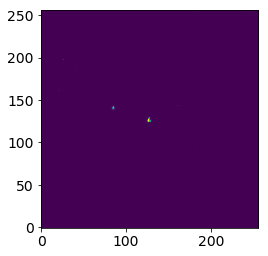

In [92]:
sub_flat_1 = g3_flat-g2_flat
sub_flat_2 = g1_flat-g2_flat
sub_flat_3 = g3_flat-g1_flat
flat_g = (((sub_flat_2-sub_flat_1)+(sub_flat_3-sub_flat_2)+(sub_flat_3-sub_flat_1))/3)/2.805
flat_1_g = flat_g.truncate(before=0, after=255)
flat_final_g = flat_1_g.truncate(before=0, after=255, axis='columns')

sub_flat_4 = r3_flat-r2_flat
sub_flat_5 = r1_flat-r2_flat
sub_flat_6 = r3_flat-r1_flat
flat_r = (((sub_flat_5-sub_flat_4)+(sub_flat_6-sub_flat_5)+(sub_flat_6-sub_flat_4))/3)/2.805
flat_1_r = flat_r.truncate(before=0, after=255)
flat_final_r = flat_1_r.truncate(before=0, after=255, axis='columns')

bias_final = ((Bias_1 + Bias_2)/2)
bias_final

flat_mean_r = flat_r.values.mean()
flat_mean_g = flat_g.values.mean()

EW_final_r = (EW_Sct_r-flat_mean_r-bias_final)
EW_final_g = (EW_Sct_g-flat_mean_g-bias_final)
EW_final = (EW_final_g+EW_final_r)/2

plt.imshow(EW_final, cmap='viridis', aspect=1, interpolation='nearest',origin='lower') 

In [93]:
#from sklearn import preprocessing
#float_array = EW_final.values.astype(float)
#min_max_scaler = preprocessing.MinMaxScaler()
#scaled_array = min_max_scaler.fit_transform(float_array)
#EW_normalized = pd.DataFrame(scaled_array)

#fig, ax =plt.subplots(1,1)
#fig.set_size_inches(8,8)
#plt.imshow(EW_normalized, cmap='viridis', aspect=1, interpolation='nearest',origin='lower')
#plt.colorbar(orientation='horizontal', fraction=0.045, pad=0.08)

In [94]:
file = EW_final
hdu = file[0]
#hdu.scale('int64','bzero')
data = hdu.data[:]    
mean, median, std = sigma_clipped_stats(data, sigma=3.0)    
print((mean, median, std)) 

(14.639482999335112, 12.841064027003199, 17.988986460164668)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Series.data is deprecated and will be removed in a future version
  after removing the cwd from sys.path.


In [95]:

daofind = DAOStarFinder(fwhm=2, threshold=5.*std)    
sources = daofind(EW_final - median)    
for col in sources.colnames:    
    sources[col].info.format = '%.8g'  # for consistent table output
print(sources)  

 id xcentroid ycentroid sharpness  ... sky  peak     flux        mag     
--- --------- --------- ---------- ... --- ------ --------- -------------
  1   189.632 6.8690032 0.87985777 ...   0    100 1.2089247   -0.20599809
  2 54.435181 11.521075  0.6007177 ...   0     76 1.1636135   -0.16452192
  3 192.72693    12.993 0.97999143 ...   0  144.5 1.6486738   -0.54283683
  4 2.6602737 15.482867 0.97184406 ...   0  173.5  1.557195   -0.48085751
  5 6.6557541 15.050281 0.92482206 ...   0  119.5 1.1553051    -0.1567417
  6 13.297985 16.118027 0.88813324 ...   0  120.5 1.2342783   -0.22853276
  7 221.59071 18.040773 0.89024931 ...   0    711  7.587771    -2.2002855
  8 244.75744 19.281865 0.97517263 ...   0    120  1.438935   -0.39510293
  9 233.68493 25.562685 0.78946897 ...   0  191.5 2.4502552    -0.9730283
 10 94.483182 36.887614 0.88351723 ...   0  139.5 1.6677176   -0.55530628
...       ...       ...        ... ... ...    ...       ...           ...
 28 86.738053  173.0061 0.90404602 ...

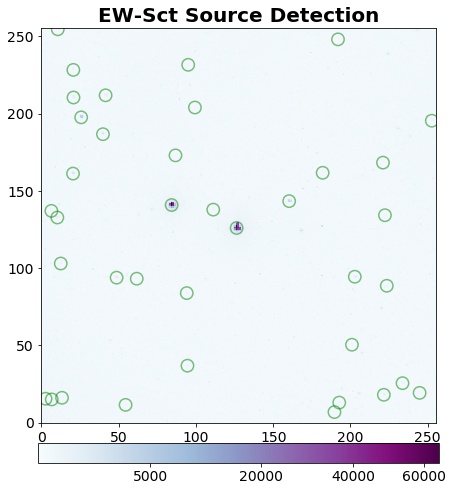

In [96]:
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=4.)
norm = ImageNormalize(stretch=SqrtStretch())

fig, ax =plt.subplots(1,1)
fig.set_size_inches(8,8)
plt.imshow(EW_final, cmap='BuPu', origin='lower', norm=norm)
apertures.plot(color='green', lw=1.5, alpha=0.5)

ax.set_title('EW-Sct Source Detection', fontdict={'fontsize': 20, 'fontweight': 'heavy'})


plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.0445, ticks=[5000, 20000, 40000, 60000]) 

In [97]:
sources.pprint(max_lines=-1, max_width=-1)

 id xcentroid ycentroid sharpness   roundness1    roundness2   npix sky   peak     flux        mag     
--- --------- --------- ---------- ------------ -------------- ---- --- ------- --------- -------------
  1   189.632 6.8690032 0.87985777  -0.19000716    -0.19167936   25   0     100 1.2089247   -0.20599809
  2 54.435181 11.521075  0.6007177  -0.59696885    -0.26663228   25   0      76 1.1636135   -0.16452192
  3 192.72693    12.993 0.97999143  -0.33390635    -0.30095692   25   0   144.5 1.6486738   -0.54283683
  4 2.6602737 15.482867 0.97184406   0.13892439     0.12560406   25   0   173.5  1.557195   -0.48085751
  5 6.6557541 15.050281 0.92482206   0.66545174     0.19918922   25   0   119.5 1.1553051    -0.1567417
  6 13.297985 16.118027 0.88813324    0.7550088    -0.14798086   25   0   120.5 1.2342783   -0.22853276
  7 221.59071 18.040773 0.89024931  -0.47142198    -0.38788578   25   0     711  7.587771    -2.2002855
  8 244.75744 19.281865 0.97517263  -0.29911279     0.11118428  

In [98]:
from astropy.stats import sigma_clipped_stats
from photutils import find_peaks
data = EW_final
mean, median, std = sigma_clipped_stats(data, sigma=3.0)
threshold = median + (5. * std)
tbl = find_peaks(data, threshold, box_size=11)
tbl['peak_value'].info.format = '%.8g'  # for consistent table output
print(tbl[:10])    # print only the first 10 peaks

x_peak y_peak peak_value
------ ------ ----------
    81      1  567.34106
    18      2  443.34106
    62      3  97.841064
   176      3  68.841064
   219      3  131.84106
   230      3  140.84106
     7      4  155.84106
   152      5  67.841064
   183      5  125.84106
   207      5  412.84106


In [99]:
HD_mag_source = -7.241145
HD_mag_HIP = (7.8+8.1176)/2
EW_mag_source = -6.9182232
#sources.pprint(max_lines=-1, max_width=-1)
conversion_factor = HD_mag_HIP+np.abs(HD_mag_source)
print(EW_mag_source+conversion_factor)
#HD_mag_source

8.2817218


In [100]:
cepheid_table = pd.read_csv('/Users/Hoops/Desktop/Astr480/aavsodata_5cec2e23755ae.csv')
cepheid_table.count
cepheid_table

,JD,Magnitude,Uncertainty,HQuncertainty,Band,Observer Code,Comment Code(s),Comp Star 1,Comp Star 2,Charts,...,Cmag,Kmag,HJD,Star Name,Observer Affiliation,Measurement Method,Grouping Method,ADS Reference,Digitizer,Credit
0,2.439354e+06,7.900,NaN,NaN,Vis.,CMA,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,EW SCT,NaN,STD,NaN,NaN,NaN,NaN
1,2.442601e+06,8.400,NaN,NaN,Vis.,LKS,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,EW SCT,NaN,STD,NaN,NaN,NaN,NaN
2,2.452877e+06,8.500,NaN,NaN,Vis.,GGC,NaN,79,88,GEOS,...,NaN,NaN,NaN,EW SCT,NaN,STD,NaN,NaN,NaN,NaN
3,2.452907e+06,7.900,NaN,NaN,Vis.,RJG,NaN,78,80,SB1986,...,NaN,NaN,NaN,EW SCT,NaN,STD,NaN,NaN,NaN,NaN
4,2.452907e+06,7.900,NaN,NaN,Vis.,CAI,NaN,78,80,SB1986,...,NaN,NaN,NaN,EW SCT,NaN,STD,NaN,NaN,NaN,NaN
5,2.453224e+06,7.900,NaN,NaN,Vis.,RJG,NaN,78,80,SB1986,...,NaN,NaN,NaN,EW SCT,NaN,STD,NaN,NaN,NaN,NaN
6,2.453224e+06,7.900,NaN,NaN,Vis.,CAI,NaN,76,78,SB1986,...,NaN,NaN,NaN,EW SCT,NaN,STD,NaN,NaN,NaN,NaN
7,2.453263e+06,7.900,NaN,NaN,Vis.,RJG,NaN,78,80,SB1986,...,NaN,NaN,NaN,EW SCT,NaN,STD,NaN,NaN,NaN,NaN
8,2.453263e+06,7.900,NaN,NaN,Vis.,CAI,NaN,78,80,SB1986,...,NaN,NaN,NaN,EW SCT,NaN,STD,NaN,NaN,NaN,NaN
9,2.453581e+06,7.900,NaN,NaN,Vis.,RJG,NaN,78,80,SB1986,...,NaN,NaN,NaN,EW SCT,NaN,STD,NaN,NaN,NaN,NaN


In [101]:
conversion factor 

SyntaxError: invalid syntax (<ipython-input-101-88c10b6e4edd>, line 1)

from scipy.optimize import leastsq

N = 100 # number of data points
t = np.linspace(2.45525e+06, 2.455315e+06, 194)
f = 1.15247 # Optional!! Advised not to use
data = cepheid_table['Magnitude']

guess_mean = np.mean(data)
guess_std = 3*np.std(data)/(2**0.5)/(2**0.5)
guess_phase = 0
guess_freq = 1
guess_amp = 1

# we'll use this to plot our first estimate. This might already be good enough for you
data_first_guess = guess_std*np.sin(t+guess_phase) + guess_mean

# Define the function to optimize, in this case, we want to minimize the difference
# between the actual data and our "guessed" parameters
optimize_func = lambda x: x[0]*np.sin(x[1]*t+x[2]) + x[3] - data
est_amp, est_freq, est_phase, est_mean = leastsq(optimize_func, [guess_amp, guess_freq, guess_phase, guess_mean])[0]

# recreate the fitted curve using the optimized parameters
data_fit = est_amp*np.sin(est_freq*t+est_phase) + est_mean

# recreate the fitted curve using the optimized parameters

fine_t = np.arange(0,max(t),0.1)
data_fit=est_amp*np.sin(est_freq*fine_t+est_phase)+est_mean

ax.set_xlim(2.455266e+06, 2.455293e+06)
ax.plot(t, data, '.')
ax.plot(t, data_first_guess, label='first guess')
ax.plot(fine_t, data_fit, label='after fitting')
ax.legend()
plt.show

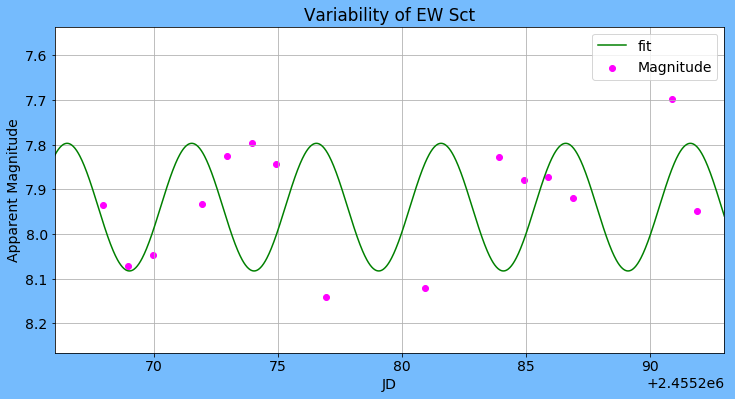

In [153]:

is_vis =  cepheid_table['Band']=='V'
vis_dt = cepheid_table[is_vis]

Z = np.linspace(2.45525e+06, 2.455315e+06, 3000)
x_data = np.linspace(0, 2.455315e+06, 100)
var_jd = vis_dt['JD']

fig, ax =plt.subplots(1,1)
fig.set_size_inches(12,6)

#plt.plot(x_data, guess(x_data, *popt), 'r-',
#         label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

ax.plot(Z, ((np.sin(Z/.8)/7)+7.94), 'g-', label='fit')
ax.scatter(vis_dt['JD'], vis_dt['Magnitude'], marker='o', color='magenta')
ax.set_xlabel('JD')
ax.set_ylabel('Apparent Magnitude')
ax.set_xlim(2.455266e+06, 2.455293e+06)
#ax.set_xlim(2.4546e+06, 2.454690e+06)
#ax.set_xlim(0,50)
ax.set_title('Variability of EW Sct')
fig.patch.set_facecolor('xkcd:sky blue')
plt.legend()
plt.gca().invert_yaxis()
plt.grid()

In [103]:
def guess(x, a, b, c):
     return a * np.sin(b * x) + c

y = guess(x_data, 1,1,1)
popt, pcov = curve_fit(guess, x_data, y)
plt.plot(x_data, guess(x_data, *popt), 'r-',
         label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
ax.set_xlim(2.455266e+06, 2.455293e+06)

NameError: name 'curve_fit' is not defined

In [206]:
var_jd

21     2.454619e+06
22     2.454620e+06
23     2.454621e+06
24     2.454622e+06
25     2.454623e+06
26     2.454624e+06
27     2.454626e+06
28     2.454627e+06
29     2.454629e+06
30     2.454630e+06
31     2.454631e+06
32     2.454632e+06
33     2.454634e+06
34     2.454653e+06
35     2.454654e+06
36     2.454660e+06
37     2.454668e+06
38     2.454677e+06
39     2.454680e+06
40     2.454681e+06
41     2.454944e+06
42     2.454946e+06
43     2.454948e+06
44     2.454952e+06
45     2.454953e+06
46     2.454958e+06
47     2.454980e+06
54     2.455261e+06
59     2.455262e+06
60     2.455268e+06
65     2.455269e+06
70     2.455270e+06
75     2.455272e+06
77     2.455273e+06
83     2.455274e+06
86     2.455275e+06
90     2.455277e+06
95     2.455281e+06
97     2.455284e+06
101    2.455285e+06
107    2.455286e+06
108    2.455287e+06
114    2.455291e+06
119    2.455292e+06
120    2.455294e+06
124    2.455295e+06
130    2.455297e+06
132    2.455299e+06
138    2.455312e+06
141    2.455313e+06


In [230]:
from astropy.table import Table
dat = Table.read('/Users/Hoops/Desktop/Astr480/Baade-Wesselink.fit', format='fits')
df = dat.to_pandas()
Baade_data = df.drop(columns=['M','V','Loc', '_RAJ2000', '_DEJ2000'])
Baade_data.head(10)

,Name,E_B-V_,e_E_B-V_,Per,p,Dist,e_Dist,VMAG,e_VMAG,KMAG,e_KMAG,Simbad,_RA,_DE
0,b'AK Cep ',0.635,0.049,7.233310,1.294,4035.8,378.2,-3.90,0.26,-5.52,0.20,b'Simbad',337.20869,58.21095
1,b'AN Aur ',0.600,0.057,10.289226,1.257,5301.6,544.2,-5.13,0.29,-6.56,0.21,b'Simbad',74.92308,40.83604
2,b'AQ Pup ',0.518,0.010,30.095462,1.145,2991.1,80.8,-5.31,0.07,-7.27,0.06,b'Simbad',119.59205,-29.13009
3,b'AV Sgr ',1.267,0.078,15.411587,1.215,2452.7,104.0,-4.77,0.28,-6.66,0.10,b'Simbad',271.20325,-22.73239
4,b'AW Per ',0.489,0.011,6.463585,1.305,971.5,79.4,-4.06,0.18,-5.41,0.17,b'Simbad',71.94299,36.72280
5,b'BB Sgr ',0.281,0.009,6.637113,1.303,814.3,25.8,-3.53,0.07,-5.15,0.07,b'Simbad',282.74947,-20.29523
6,b'BE Mon ',0.565,0.038,2.705541,1.396,1884.0,283.2,-2.66,0.33,-3.86,0.30,b'Simbad',100.02326,7.60583
7,b'beta Dor ',0.052,0.009,9.842554,1.262,329.5,6.0,-4.00,0.05,-5.65,0.04,b'Simbad',83.40632,-62.48982
8,b'BF Oph ',0.235,0.010,4.067677,1.354,760.2,32.2,-2.82,0.10,-4.31,0.09,b'Simbad',256.52291,-26.58056
9,b'BG Lac ',0.300,0.016,5.331921,1.326,1760.4,74.4,-3.31,0.10,-4.80,0.09,b'Simbad',330.10477,43.44537


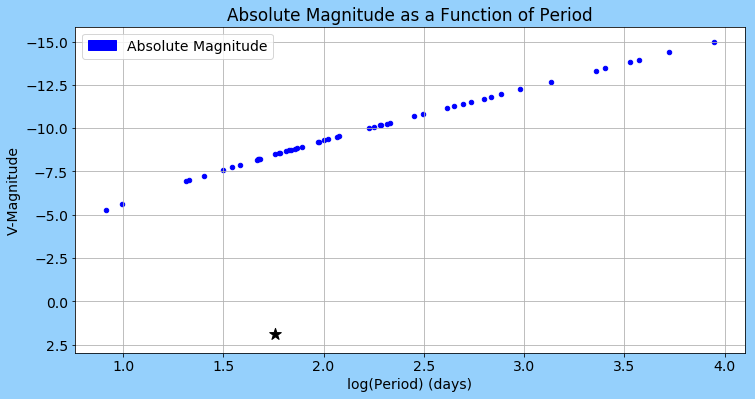

In [105]:
import matplotlib.patches as mpatches
fig, ax =plt.subplots(1,1)
fig.set_size_inches(12,6)

EW_Sct = 5.8
dots_patch = mpatches.Patch(color='blue', label='Absolute Magnitude', hatch='.')

#ax.text(1.7, 2.3, "EW-Sct", ha="center", va="center", rotation=0, size=15)
#ax.scatter((Baade_data['Per']), (Baade_data['VMAG']), marker='o', color='blue')
ax.scatter(np.log(Baade_data['Per']), ((-2.76 * np.log(Baade_data['Per']-1))-4.16), color='blue', marker='.', s=80)
ax.scatter(np.log(EW_Sct),((2.76 * np.log(10-1))-4.16), marker='*', color='black', s=150)
ax.set_xlabel('log(Period) (days)')
ax.set_ylabel('V-Magnitude')
#ax.set_xlim(0,6)
#ax.set_ylim(-8,-2)
plt.gca().invert_yaxis()
ax.set_title('Absolute Magnitude as a Function of Period')
fig.patch.set_facecolor('xkcd:light blue')
plt.legend(handles=[dots_patch])
plt.grid()

Raw fit results:
poly([-5.02429587e-16 -3.33333333e+00])
[array([3.30605134e-30]), 2, array([1.3976897 , 0.21555392]), 1.1102230246251565e-14]
Fit: Mag = -3.333[log(days)] + -0.000 (rms residual = 0.0000)


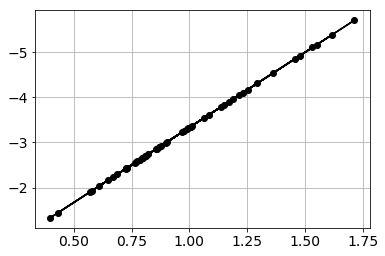

In [207]:
import numpy as np
import pylab
Polynomial = np.polynomial.Polynomial

# The data: conc = [P] and absorbance, A
Period = np.array(np.log10(Baade_data['Per']))
Mag = -(np.log10(Baade_data['Per'])/.3)

cmin, cmax = min(Period), max(Period)
pfit, stats = Polynomial.fit(Period, Mag, 1, full=True, window=(cmin, cmax),
                                                    domain=(cmin, cmax))

print('Raw fit results:', pfit, stats, sep='\n')

A0, m = pfit
resid, rank, sing_val, rcond = stats
rms = np.sqrt(resid[0]/len(Mag))

print('Fit: Mag = {:.3f}[log(days)] + {:.3f}'.format(m, A0),
      '(rms residual = {:.4f})'.format(rms))

pylab.plot(Period, Mag, 'o', color='k')
pylab.plot(Period, pfit(Period), color='k')
ax.set_xlabel('Period (days)')
ax.set_ylabel('Magnitude')
ax.set_xlim(0,6)
ax.set_ylim(-15,0)
plt.gca().invert_yaxis()
ax.set_title('Period vs. Absolute Magnitude')
fig.patch.set_facecolor('xkcd:sky blue')
plt.grid()

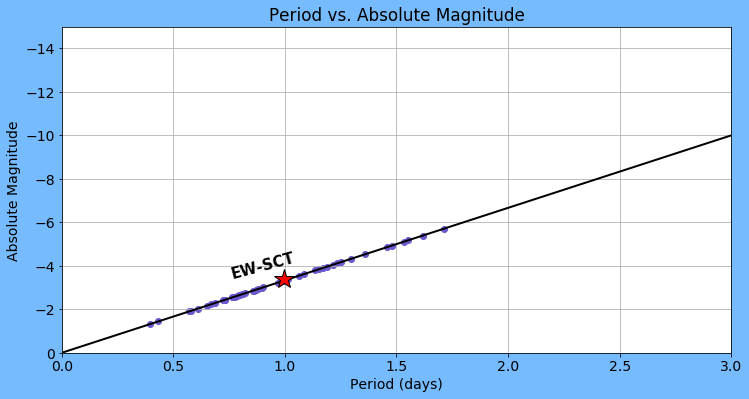

In [224]:
fig, ax =plt.subplots(1,1)
fig.set_size_inches(12,6)

J = np.linspace(0, 10, 50)
pylab.plot(J, -((J)/.3), color='k', linewidth = 2)
#pylab.plot(J, (-2.76*J)-3.16, color='k', linewidth = 2)


ax.text(.9, -4, "EW-SCT", ha="center", va="center", rotation=15, size=15, weight='bold')
ax.plot(np.log10(9.92), -2.45 * (np.log10(9.92)-1)-3.4, marker='*', color = 'r', markersize=20, markeredgecolor='black')
#ax.plot(np.log10(5.8), -(np.log10(5.82363)/.3), marker='*', color = 'gold',markeredgecolor='black', markersize=20)
#ax.scatter(np.log10(Baade_data['Per']), -(2.76 * np.log10(Baade_data['Per'])-1)-4.16, marker='o', color ='slateblue')
ax.scatter(np.log10(Baade_data['Per']), -(np.log10(Baade_data['Per'])/.3), marker='o', color='slateblue')
ax.set_xlabel('Period (days)')
ax.set_ylabel('Absolute Magnitude')
ax.set_xlim(0,3)
ax.set_ylim(-15,0)
plt.gca().invert_yaxis()
ax.set_title('Period vs. Absolute Magnitude')
fig.patch.set_facecolor('xkcd:sky blue')
plt.grid()

In [ ]:
from matplotlib import rcParams
rcParams['font.size'] = 14
plt.imshow(EW_final, cmap='Greys', aspect=1, interpolation='nearest',origin='lower') 
plt.title('PSF') 
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)

$$Distance\space =\space 10^{\frac{m_{app}\space -\space M_{abs}\space+5}{5}}$$